## Import des modules## Import

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime

bc = pd.read_csv('seatle.csv')

## Selection des batiments non residentiels

In [246]:
print(f"Nombre totale de batiments: {len(bc)}")
bc = bc[~bc['BuildingType'].str.contains('Multifamily', na=False)]
print(f"Nombre de batiments non residentiels: {len(bc)}")

Nombre totale de batiments: 3376
Nombre de batiments non residentiels: 1668


# TRAITEMENT DES COLONNES ET DES LIGNES

## Suppression des colonnes vides, avec des données manquantes, à zéro ou constantes
- Comments >>> Colonne vide
- Outlier >>> Valeurs manquantes
- YearsENERGYSTARCertified >>> Valeurs manquantes
- ThirdLargestPropertyUseType >>> Valeurs manquantes
- ThirdLargestPropertyUseTypeGFA >>> Valeurs manquantes
- SecondLargestPropertyUseType >>> Valeurs manquantes
- SecondLargestPropertyUseTypeGFA >>> Valeurs manquantes
- ENERGYSTARScore >>> Valeurs manquantes
- DataYear, City, State >>> Valeurs constantes
- OSEBuildingID, PropertyName, Address, TaxParcelIdentificationNumber, LargestPropertyUseType, LargestPropertyUseTypeGFA,
DefaultData, CouncilDistrictCode, Latitude, Longitude, GHGEmissionsIntensity >>> Valeurs non pertinentes

- ComplianceStatus >>> Suppression de la colonne car on ne sait pas sur quelles données se baser
- BuildingType >>> Suppression car ne sera plus utilisé

- Conversion de toutes les colonnes float64 en int64 à cause des grandeurs de chiffres

In [247]:
print(f"Colonnes: {bc.shape[1]}")

bc.isnull().sum().sort_values(ascending=False)
# Suppression des colonnes avec plus de 500 données manquantes
bc = bc.loc[:, bc.isnull().sum() <= 500]
bc.isnull().sum().sort_values(ascending=False)

# Suppression des colonnes avec des données constantes
bc.columns[bc.nunique() == 1].tolist()
bc.drop((['DataYear','City','State']), axis=1, inplace=True)

# Suppression des colonnes non pertinentes
bc.drop((['OSEBuildingID', 'PropertyName', 'Address', 'TaxParcelIdentificationNumber', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'DefaultData', 'CouncilDistrictCode','Latitude', 'Longitude', 'GHGEmissionsIntensity','ComplianceStatus','BuildingType']), axis=1, inplace=True)

# Suppression des colonnes avec des valeurs à 0
(bc == 0).sum().sort_values(ascending=False)
bc.drop((['SteamUse(kBtu)']), axis=1, inplace=True)

# Sélection des colonnes float64
float_cols = bc.select_dtypes(include='float64').columns
# Arrondir et convertir en int64
for col in float_cols:
    bc[col] = bc[col].round().fillna(0).astype('int64')

print(f"Colonnes: {bc.shape[1]}")

Colonnes: 46
Colonnes: 21


## Suppression des lignes avec des données manquantes

In [248]:
bc.isnull().sum().sort_values(ascending=False)
bc.dropna(subset=['SiteEUI(kBtu/sf)'], inplace=True)
bc.dropna(subset=['SiteEUIWN(kBtu/sf)'], inplace=True)
bc.isnull().sum().sort_values(ascending=False)

ListOfAllPropertyUseTypes    2
PrimaryPropertyType          0
SiteEUIWN(kBtu/sf)           0
NaturalGas(kBtu)             0
NaturalGas(therms)           0
Electricity(kBtu)            0
Electricity(kWh)             0
SiteEnergyUseWN(kBtu)        0
SiteEnergyUse(kBtu)          0
SourceEUIWN(kBtu/sf)         0
SourceEUI(kBtu/sf)           0
SiteEUI(kBtu/sf)             0
ZipCode                      0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
PropertyGFATotal             0
NumberofFloors               0
NumberofBuildings            0
YearBuilt                    0
Neighborhood                 0
TotalGHGEmissions            0
dtype: int64

## Traitement des quartiers
- Certains quartiers sont en minuscules et 1 quartier "DELRIDGE NEIGHBORHOODS" peut etre modifié en "DELRIDGE"

In [249]:
print(bc.groupby(['Neighborhood']).size().sort_values(ascending=False))

# Mettre les valeurs en MAJUSCULE
bc['Neighborhood'] = bc['Neighborhood'].str.upper()

# Modifier le quartier "DELRIDGE NEIGHBORHOODS")" en "DELRIDGE"
bc.loc[bc['Neighborhood'] == "DELRIDGE NEIGHBORHOODS", 'Neighborhood'] = "DELRIDGE"

print(bc.groupby(['Neighborhood']).size().sort_values(ascending=False))

Neighborhood
DOWNTOWN                  361
GREATER DUWAMISH          346
MAGNOLIA / QUEEN ANNE     151
LAKE UNION                148
NORTHEAST                 128
EAST                      121
NORTHWEST                  81
BALLARD                    64
NORTH                      58
CENTRAL                    51
SOUTHEAST                  46
DELRIDGE                   42
SOUTHWEST                  41
North                       9
Ballard                     6
Central                     5
Northwest                   5
Delridge                    4
DELRIDGE NEIGHBORHOODS      1
dtype: int64
Neighborhood
DOWNTOWN                 361
GREATER DUWAMISH         346
MAGNOLIA / QUEEN ANNE    151
LAKE UNION               148
NORTHEAST                128
EAST                     121
NORTHWEST                 86
BALLARD                   70
NORTH                     67
CENTRAL                   56
DELRIDGE                  47
SOUTHEAST                 46
SOUTHWEST                 41
dtype: int64


## Traitement des codes postaux
- Sur les ZIPCODE manquants, on peut récupérer le quartier et ajouter le ZIPCODE le plus probable.

In [250]:
######## Traitement des ZipCode manquants ##########
prob = bc.groupby(['ZipCode', 'Neighborhood']).size().reset_index(name='Count')
prob = prob.loc[prob.groupby('Neighborhood')['Count'].idxmax()]
prob = prob[prob['Count'] > 10]
prob = prob.sort_values('Count', ascending=False)
print(prob)

bc = bc.merge(prob[['Neighborhood', 'ZipCode']], on='Neighborhood', how='left', suffixes=('', '_fill'))
bc['ZipCode'] = bc['ZipCode'].fillna(bc['ZipCode_fill'])
bc = bc.drop(columns=['ZipCode_fill'])

bc.isnull().sum().sort_values(ascending=False)

    ZipCode           Neighborhood  Count
85    98134       GREATER DUWAMISH    178
17    98101               DOWNTOWN    133
33    98105              NORTHEAST     81
43    98109             LAKE UNION     76
63    98119  MAGNOLIA / QUEEN ANNE     63
70    98122                   EAST     58
37    98107                BALLARD     48
81    98133              NORTHWEST     48
74    98125                  NORTH     45
69    98122                CENTRAL     35
62    98118              SOUTHEAST     29
35    98106               DELRIDGE     25
57    98116              SOUTHWEST     23


ListOfAllPropertyUseTypes    2
PrimaryPropertyType          0
SiteEUIWN(kBtu/sf)           0
NaturalGas(kBtu)             0
NaturalGas(therms)           0
Electricity(kBtu)            0
Electricity(kWh)             0
SiteEnergyUseWN(kBtu)        0
SiteEnergyUse(kBtu)          0
SourceEUIWN(kBtu/sf)         0
SourceEUI(kBtu/sf)           0
SiteEUI(kBtu/sf)             0
ZipCode                      0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
PropertyGFATotal             0
NumberofFloors               0
NumberofBuildings            0
YearBuilt                    0
Neighborhood                 0
TotalGHGEmissions            0
dtype: int64

# OUTLIERS


Fonction d'analyse IQR

In [251]:
def analyze_iqr(data, name="Dataset"):
    """Comprehensive IQR analysis of a dataset"""
    print(f"\n{name} Analysis:")
    print("-" * 30)

    q1 = np.percentile(data, 25)
    q2 = np.percentile(data, 50)  # Median
    q3 = np.percentile(data, 75)
    iqr = q3-q1

    print(f"Count: {len(data)}")
    print(f"Min: {min(data)}")
    print(f"Q1 (25%): {q1}")
    print(f"Q2 (50%, Median): {q2}")
    print(f"Q3 (75%): {q3}")
    print(f"Max: {max(data)}")
    print(f"IQR: {iqr}")
    print(f"IQR as % of range: {iqr / (max(data) - min(data)) * 100:.1f}%")

    # Outlier analysis
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = [x for x in data if x < lower_bound or x > upper_bound]

    print(f"Outlier bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"Number of outliers: {len(outliers)}")
    return outliers


## Traitement des outliers
- NumberofBuildings : Max 111 >>> CAMPUS >>> Suppression de la donnée car aberrant
- NumberofBuildings : Remplacer 0 par 1 car il y a au moins 1 batiment pour chaque ligne
- NumberofFloors : Max 99 >>> CHURCH >>> Modification à 1 étage
- NumberofFloors : Suppression des batiments superieur à 50 etages >>> Valeur aberrante
- ElectricitykWh : Min -33826.80078 Max 80460872 >>> Valeur aberrante
- TotalGHGEmissions : Min -0,8 / Max 16870,98 >>> Valeur aberrante

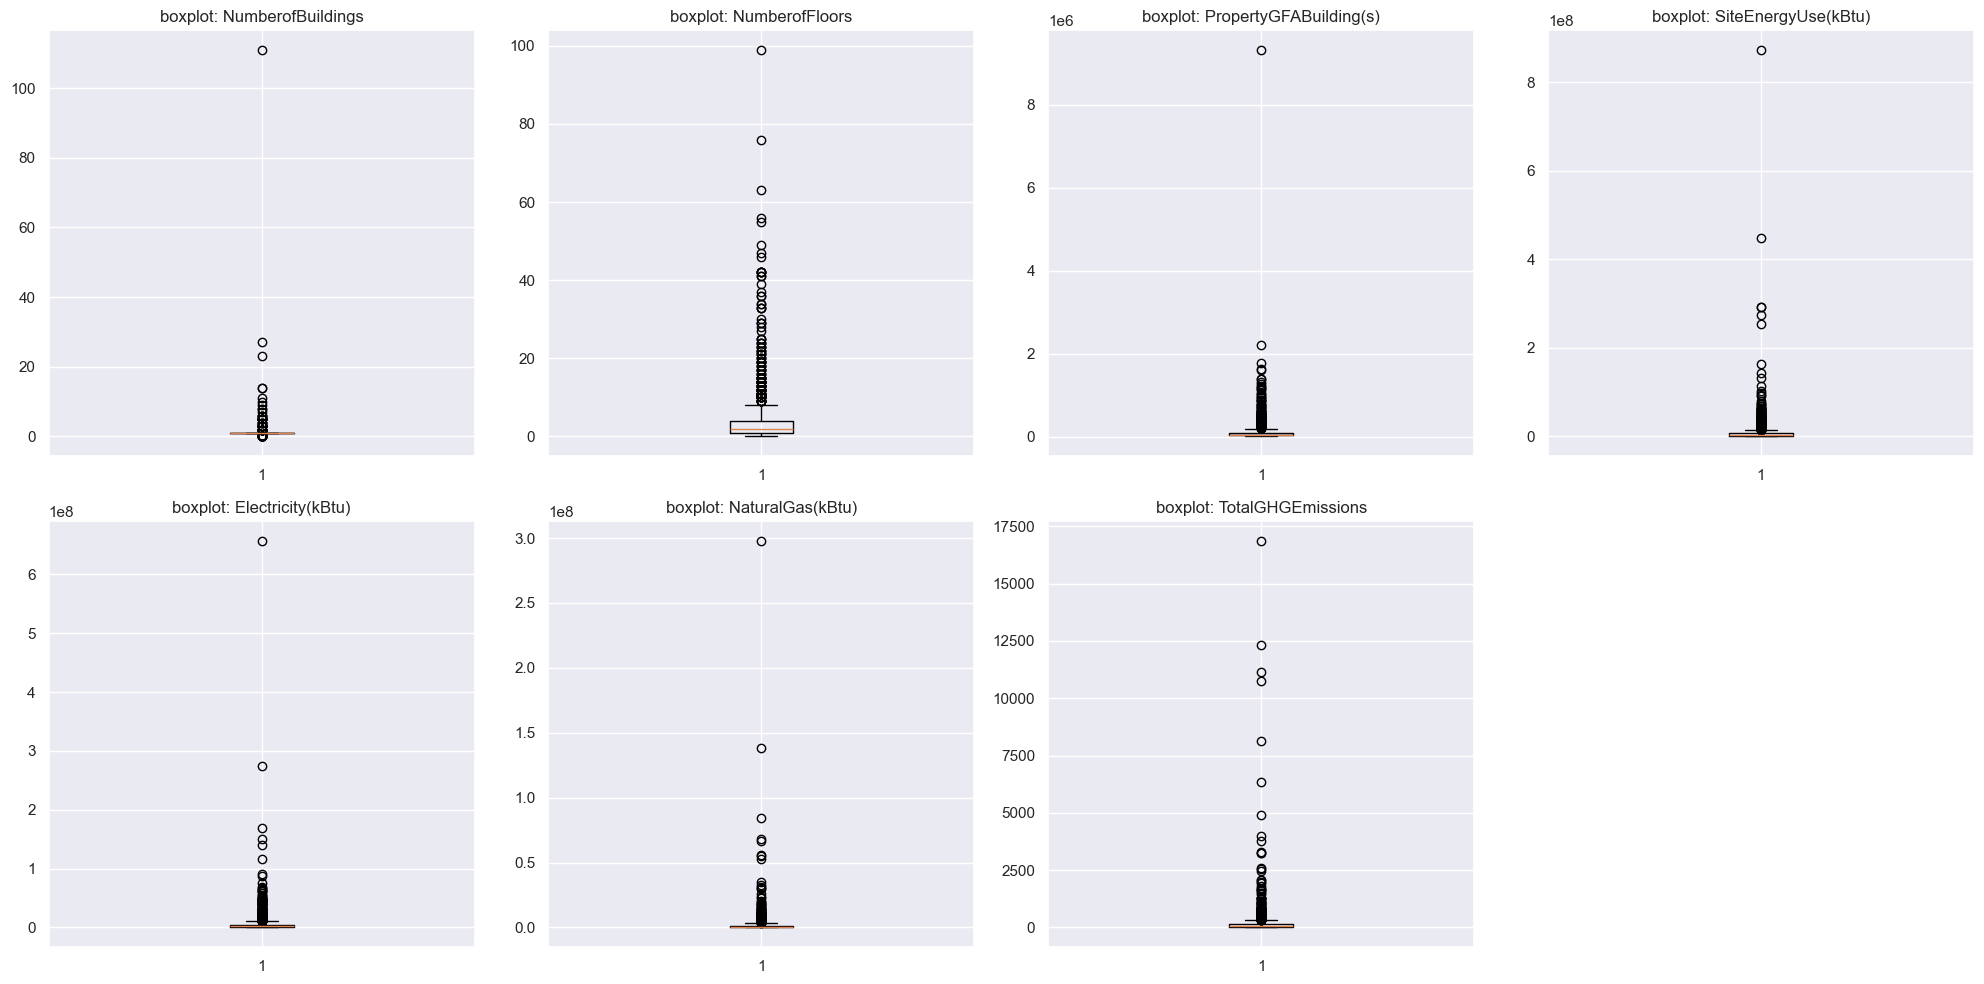


Electricity(kBtu) Analysis:
------------------------------
Count: 1668
Min: -115417
Q1 (25%): 720347.25
Q2 (50%, Median): 1609991.5
Q3 (75%): 4832694.25
Max: 657074389
IQR: 4112347.0
IQR as % of range: 0.6%
Outlier bounds: [-5448173.25, 11001214.75]
Number of outliers: 193

NaturalGas(kBtu) Analysis:
------------------------------
Count: 1668
Min: 0
Q1 (25%): 0.0
Q2 (50%, Median): 496773.5
Q3 (75%): 1515132.75
Max: 297909000
IQR: 1515132.75
IQR as % of range: 0.5%
Outlier bounds: [-2272699.12, 3787831.88]
Number of outliers: 184

TotalGHGEmissions Analysis:
------------------------------
Count: 1668
Min: -1
Q1 (25%): 20.0
Q2 (50%, Median): 50.0
Q3 (75%): 142.0
Max: 16871
IQR: 122.0
IQR as % of range: 0.7%
Outlier bounds: [-163.00, 325.00]
Number of outliers: 179

SiteEnergyUse(kBtu) Analysis:
------------------------------
Count: 1668
Min: 0
Q1 (25%): 1223105.25
Q2 (50%, Median): 2552393.0
Q3 (75%): 6905485.5
Max: 873923712
IQR: 5682380.25
IQR as % of range: 0.7%
Outlier bounds: [-730

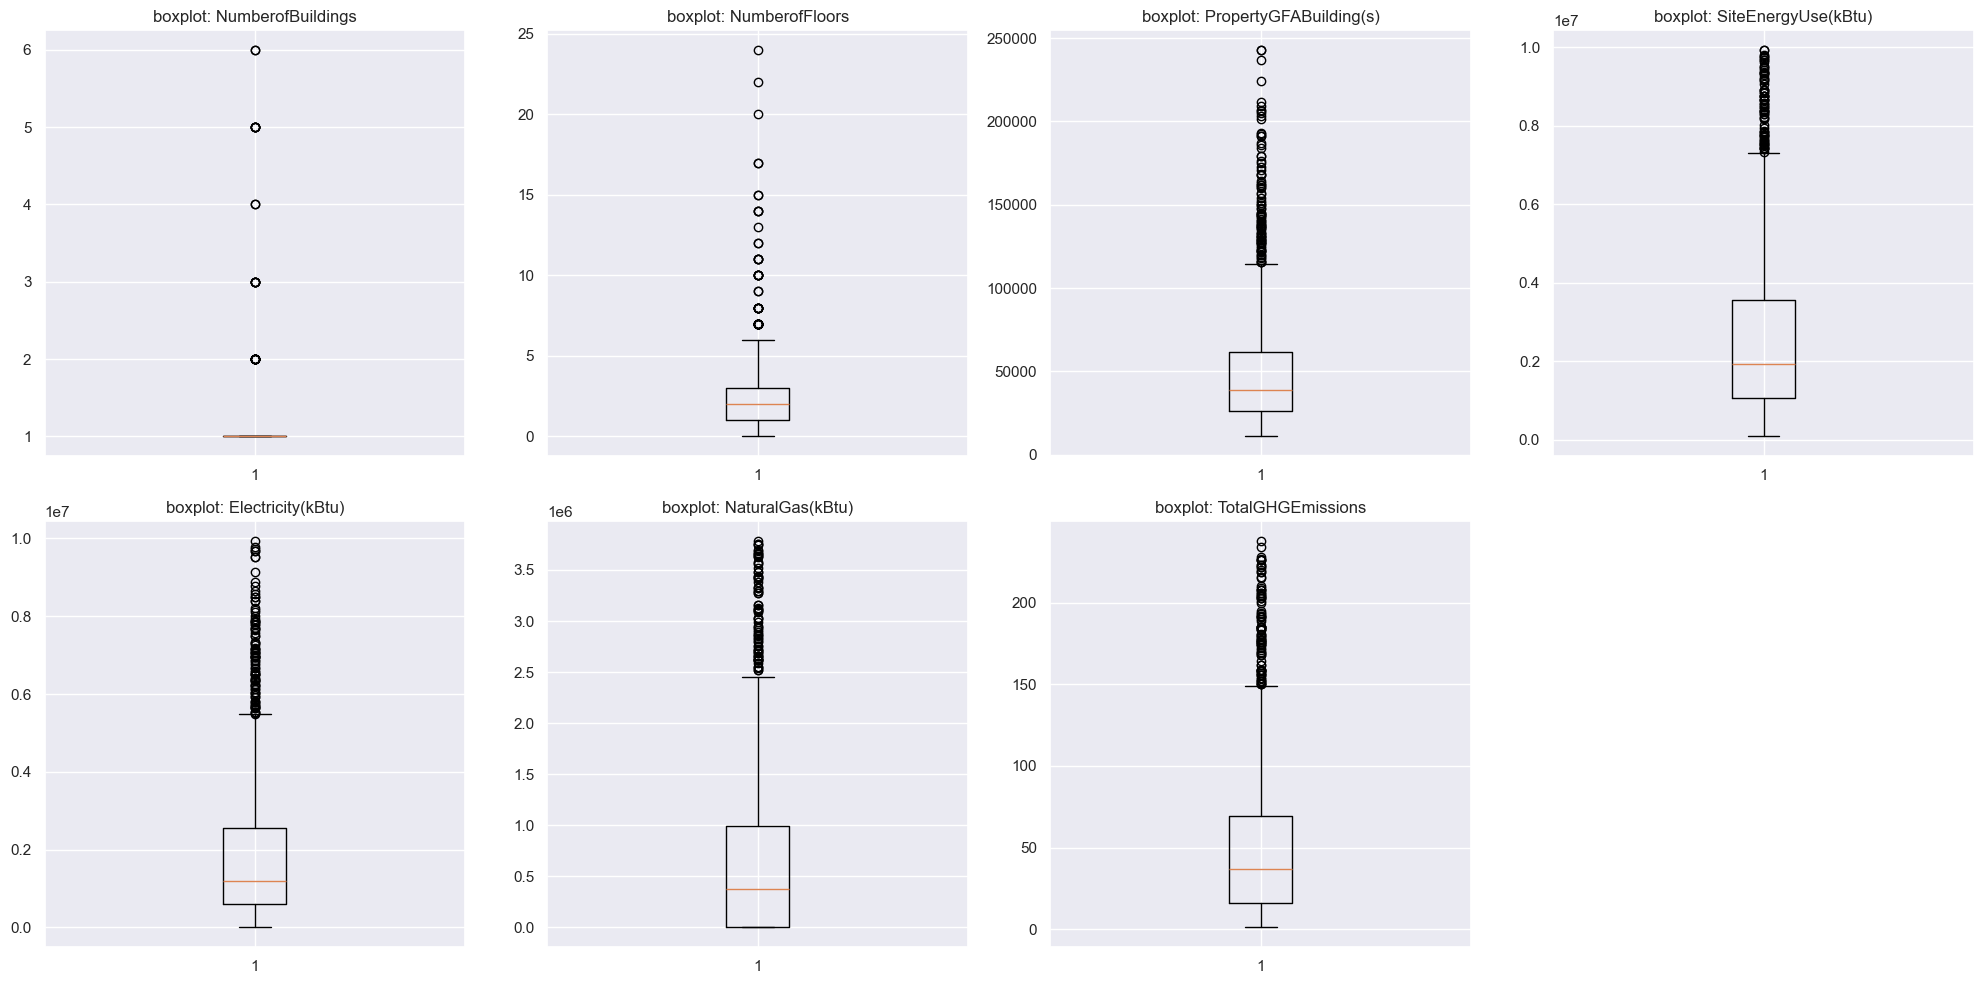

In [252]:
#############################################
#############################################

plt.figure(figsize=(20, 10))

plt.subplot(2, 4, 1)
plt.boxplot(bc['NumberofBuildings'])
plt.title('boxplot: NumberofBuildings')
plt.subplot(2, 4, 2)
plt.boxplot(bc['NumberofFloors'])
plt.title('boxplot: NumberofFloors')
plt.subplot(2, 4, 3)
plt.boxplot(bc['PropertyGFABuilding(s)'])
plt.title('boxplot: PropertyGFABuilding(s)')
plt.subplot(2, 4, 4)
plt.boxplot(bc['SiteEnergyUse(kBtu)'])
plt.title('boxplot: SiteEnergyUse(kBtu)')
#############################################
plt.subplot(2, 4, 5)
plt.boxplot(bc['Electricity(kBtu)'])
plt.title('boxplot: Electricity(kBtu)')
plt.subplot(2, 4, 6)
plt.boxplot(bc['NaturalGas(kBtu)'])
plt.title('boxplot: NaturalGas(kBtu)')
plt.subplot(2, 4, 7)
plt.boxplot(bc['TotalGHGEmissions'])
plt.title('boxplot: TotalGHGEmissions')

plt.tight_layout()
plt.show()

#############################################
#############################################

#NumberofBuildings = analyze_iqr(bc['NumberofBuildings'], "NumberofBuildings")
#NumberofFloors = analyze_iqr(bc['NumberofFloors'], "NumberofFloors")
ElectricitykBtu = analyze_iqr(bc['Electricity(kBtu)'], "Electricity(kBtu)")
NaturalGaskBtu = analyze_iqr(bc['NaturalGas(kBtu)'], "NaturalGas(kBtu)")
TotalGHGEmissions = analyze_iqr(bc['TotalGHGEmissions'], "TotalGHGEmissions")
SiteEnergyUsekBtu = analyze_iqr(bc['SiteEnergyUse(kBtu)'], "SiteEnergyUse(kBtu)")
PropertyGFABuildings = analyze_iqr(bc['PropertyGFABuilding(s)'], "PropertyGFABuilding(s)")

##################################
# Suppression des outliers
##################################

# NumberofBuildings
bc = bc.drop(bc.loc[bc['NumberofBuildings'] == 111].index)
bc.loc[bc['NumberofBuildings'] == 0, 'NumberofBuildings'] = 1

# NumberofFloors
bc.loc[bc['NumberofFloors'] == 99, 'NumberofFloors'] = 1
bc = bc.drop(bc.loc[bc['NumberofFloors'] >= 25 ].index)

# Electricity
bc.drop(bc[bc["Electricity(kBtu)"].isin(ElectricitykBtu)].index, inplace=True)

# GAS
bc.drop(bc[bc["NaturalGas(kBtu)"].isin(NaturalGaskBtu)].index, inplace=True)
bc = bc.drop(bc.loc[bc['TotalGHGEmissions'] <= 0 ].index)

# CO2
bc.drop(bc[bc["TotalGHGEmissions"].isin(TotalGHGEmissions)].index, inplace=True)
bc = bc.drop(bc.loc[bc['TotalGHGEmissions'] > 240 ].index)

# SiteEnergy
bc.drop(bc[bc["SiteEnergyUse(kBtu)"].isin(SiteEnergyUsekBtu)].index, inplace=True)
bc = bc.drop(bc.loc[bc['SiteEnergyUse(kBtu)'] <= 0 ].index)
bc = bc.drop(bc.loc[bc['SiteEnergyUse(kBtu)'] > 10000000 ].index)

# Surface M2
bc.drop(bc[bc["PropertyGFABuilding(s)"].isin(SiteEnergyUsekBtu)].index, inplace=True)
bc = bc.drop(bc.loc[bc['PropertyGFABuilding(s)'] > 250000 ].index)

#############################################
#############################################

plt.figure(figsize=(20, 10))

plt.subplot(2, 4, 1)
plt.boxplot(bc['NumberofBuildings'])
plt.title('boxplot: NumberofBuildings')
plt.subplot(2, 4, 2)
plt.boxplot(bc['NumberofFloors'])
plt.title('boxplot: NumberofFloors')
plt.subplot(2, 4, 3)
plt.boxplot(bc['PropertyGFABuilding(s)'])
plt.title('boxplot: PropertyGFABuilding(s)')
plt.subplot(2, 4, 4)
plt.boxplot(bc['SiteEnergyUse(kBtu)'])
plt.title('boxplot: SiteEnergyUse(kBtu)')
#############################################
plt.subplot(2, 4, 5)
plt.boxplot(bc['Electricity(kBtu)'])
plt.title('boxplot: Electricity(kBtu)')
plt.subplot(2, 4, 6)
plt.boxplot(bc['NaturalGas(kBtu)'])
plt.title('boxplot: NaturalGas(kBtu)')
plt.subplot(2, 4, 7)
plt.boxplot(bc['TotalGHGEmissions'])
plt.title('boxplot: TotalGHGEmissions')

plt.tight_layout()
plt.show()


# GRAPHIQUES

## Focus sur la consommation d'energie et la consommation de CO2
SiteEnergyUse(kBtu) et TotalGHGEmissions

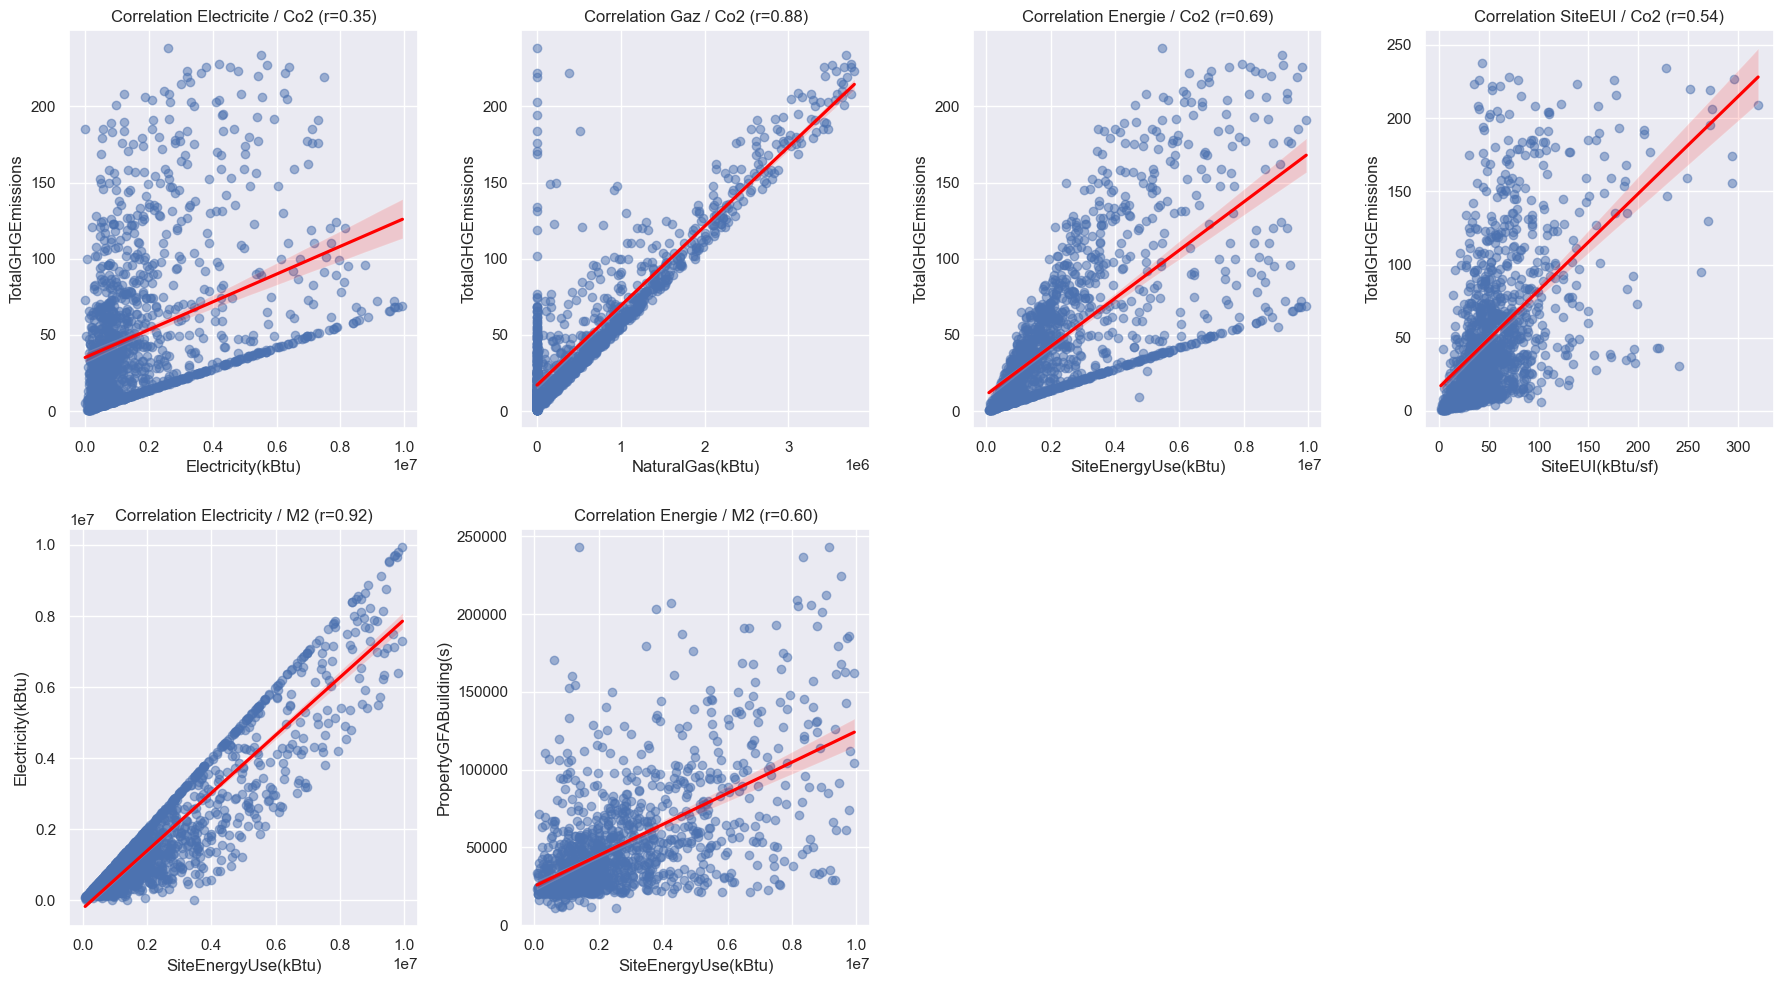

In [253]:
from scipy.stats import pearsonr

fig, axes = plt.subplots(2, 4, figsize=(18, 10))


# Scatter Electricité / CO2
r, p = pearsonr(bc['Electricity(kBtu)'], bc['TotalGHGEmissions'])
sns.regplot(x='Electricity(kBtu)', y='TotalGHGEmissions', data=bc, ax=axes[0, 0], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[0, 0].set_title(f"Correlation Electricite / Co2 (r={r:.2f})")

# Scatter Gaz / CO2
r, p = pearsonr(bc['NaturalGas(kBtu)'], bc['TotalGHGEmissions'])
sns.regplot(x='NaturalGas(kBtu)', y='TotalGHGEmissions', data=bc, ax=axes[0, 1], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[0, 1].set_title(f"Correlation Gaz / Co2 (r={r:.2f})")

# Scatter Energie / CO2
r, p = pearsonr(bc['SiteEnergyUse(kBtu)'], bc['TotalGHGEmissions'])
sns.regplot(x='SiteEnergyUse(kBtu)', y='TotalGHGEmissions', data=bc, ax=axes[0, 2], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[0, 2].set_title(f"Correlation Energie / Co2 (r={r:.2f})")

# Scatter EUI / CO2
r, p = pearsonr(bc['SiteEUI(kBtu/sf)'], bc['TotalGHGEmissions'])
sns.regplot(x='SiteEUI(kBtu/sf)', y='TotalGHGEmissions', data=bc, ax=axes[0, 3], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[0, 3].set_title(f"Correlation SiteEUI / Co2 (r={r:.2f})")

#############################

# Scatter M2 / Electricity
r, p = pearsonr(bc['SiteEnergyUse(kBtu)'], bc['Electricity(kBtu)'])
sns.regplot(x='SiteEnergyUse(kBtu)', y='Electricity(kBtu)', data=bc, ax=axes[1, 0], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[1, 0].set_title(f"Correlation Electricity / M2 (r={r:.2f})")

# Scatter SiteEnergy / M2
r, p = pearsonr(bc['SiteEnergyUse(kBtu)'], bc['PropertyGFABuilding(s)'])
sns.regplot(x='SiteEnergyUse(kBtu)', y='PropertyGFABuilding(s)', data=bc, ax=axes[1, 1], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[1, 1].set_title(f"Correlation Energie / M2 (r={r:.2f})")

axes[1, 2].axis("off")

axes[1, 3].axis("off")

plt.tight_layout()
plt.show()

## Nettoyage des colonnes redondantes
* En utilisant une matrice de corrélation de Pearson.
* Graphique Heatmap de la librairie Seaborn
- SiteEUIWN(kBtu/sf) , SourceEUIWN(kBtu/sf) , SiteEnergyUseWN(kBtu), Electricity(kWh) , NaturalGas(therms) , PropertyGFATotal
* On garde KBTU comme reference

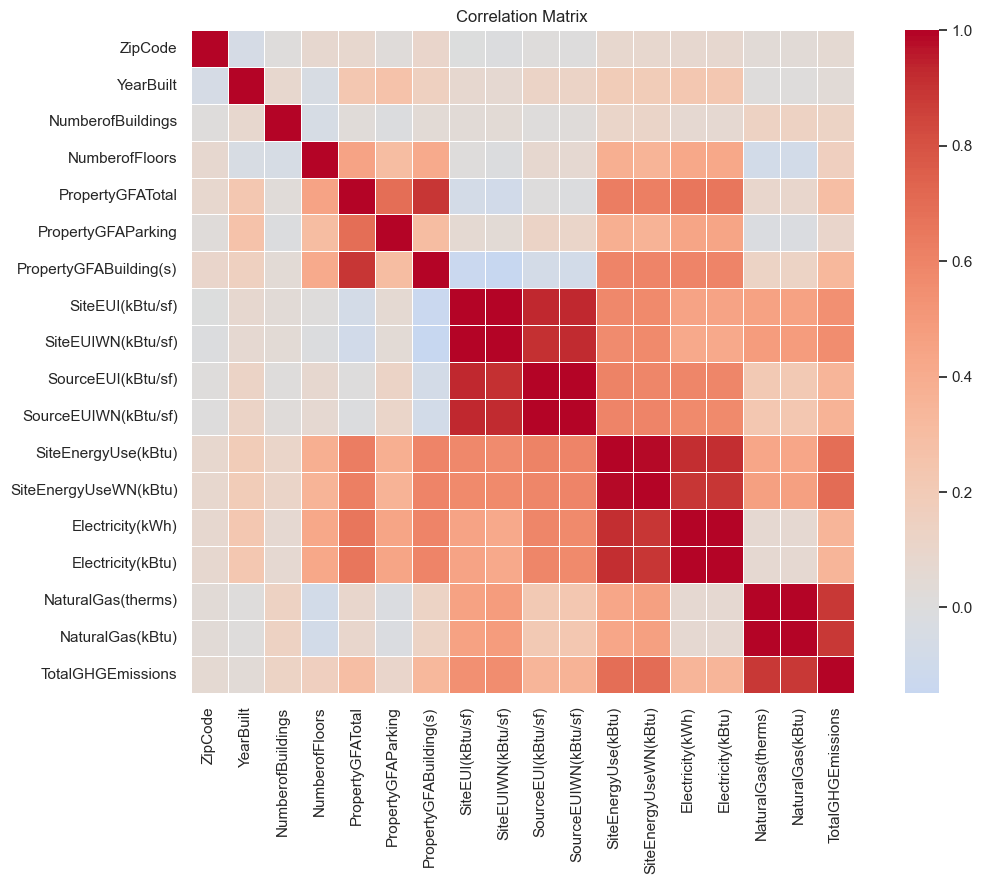

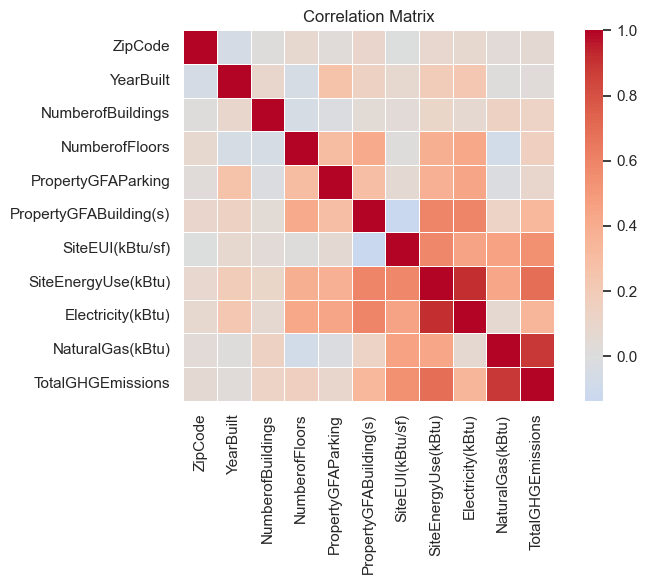

In [254]:
numeric_cols = bc.select_dtypes(include=[np.number])
corrmat = numeric_cols.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,
           cmap='coolwarm',      # Better color scheme for correlations
           center=0,             # Center colormap at 0
           square=True,
           linewidths=0.5)       # Add grid lines
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


bc.drop((['SiteEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)','SiteEnergyUseWN(kBtu)','Electricity(kWh)','NaturalGas(therms)','PropertyGFATotal']), axis=1, inplace=True)

numeric_cols = bc.select_dtypes(include=[np.number])
corrmat = numeric_cols.corr()
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corrmat,
           cmap='coolwarm',      # Better color scheme for correlations
           center=0,             # Center colormap at 0
           square=True,
           linewidths=0.5)       # Add grid lines
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


## Nettoyage des outliers sur d'autres colonnes

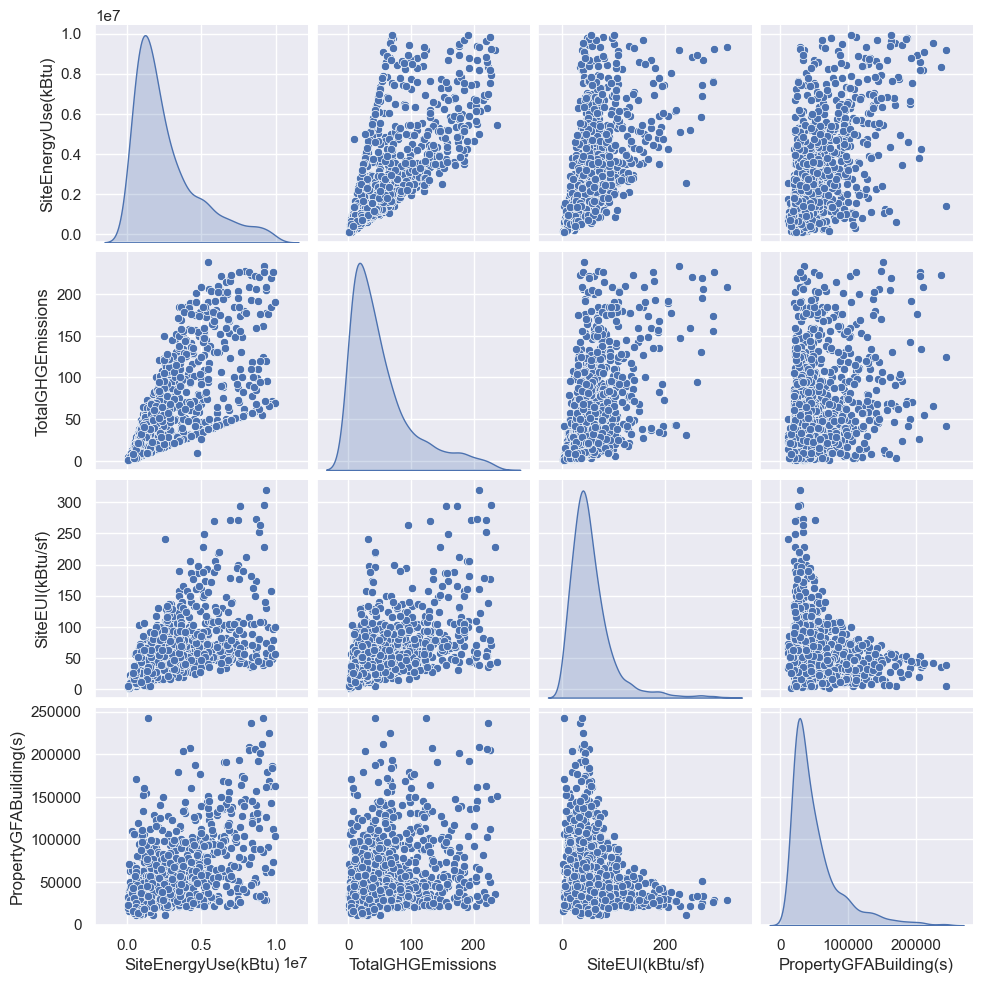

In [255]:
sns.set_theme()
# Création du pairplot
#cols = ['NumberofFloors', 'NumberofBuildings', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']
cols = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'SiteEUI(kBtu/sf)', 'PropertyGFABuilding(s)']
sns.pairplot(bc[cols], diag_kind="kde", plot_kws={"alpha":1})
plt.show()

# EXPORT CSV

In [256]:
print(f"Nombre de batiments non residentiels Traités: {len(bc)}")

# Générer la date/heure au format AAMMJJHHMMSS
timestamp = datetime.now().strftime("%y%m%d%H%M%S")
# Nom du fichier avec la date
filename_export = f"seatle_{timestamp}.csv"
filename = f"seatle_after_analyze.csv"
# Export CSV
bc.to_csv(f'exports/{filename_export}', index=False)
bc.to_csv(f'{filename}', index=False)

Nombre de batiments non residentiels Traités: 1295
